In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [2]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from time import time
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [3]:
#We are using the pre-trained Detectron2 model, as shown below.
cfg = get_cfg()

cfg.MODEL.DEVICE = "cuda"
# load the pre trained model from Detectron2 model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
# set confidence threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# load model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
# create the predictor for pose estimation using the config

In [4]:
import numpy as np
import glob

predictor = DefaultPredictor(cfg)

[03/17 16:53:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl ...


In [5]:
def coco2h36m(x):
    '''
        Input: x (M x T x V x C)

        COCO: {0-nose 1-Leye 2-Reye 3-Lear 4Rear 5-Lsho 6-Rsho 7-Lelb 8-Relb 9-Lwri 10-Rwri 11-Lhip 12-Rhip 13-Lkne 14-Rkne 15-Lank 16-Rank}

        H36M:
        0: 'root',
        1: 'rhip',
        2: 'rkne',
        3: 'rank',
        4: 'lhip',
        5: 'lkne',
        6: 'lank',
        7: 'belly',
        8: 'neck',
        9: 'nose',
        10: 'head',
        11: 'lsho',
        12: 'lelb',
        13: 'lwri',
        14: 'rsho',
        15: 'relb',
        16: 'rwri'
    '''
    y = np.zeros(x.shape)
    y[:,0,:] = (x[:,11,:] + x[:,12,:]) * 0.5
    y[:,1,:] = x[:,12,:]
    y[:,2,:] = x[:,14,:]
    y[:,3,:] = x[:,16,:]
    y[:,4,:] = x[:,11,:]
    y[:,5,:] = x[:,13,:]
    y[:,6,:] = x[:,15,:]
    y[:,8,:] = (x[:,5,:] + x[:,6,:]) * 0.5
    y[:,7,:] = (y[:,0,:] + y[:,8,:]) * 0.5
    y[:,9,:] = x[:,0,:]
    y[:,10,:] = (x[:,1,:] + x[:,2,:]) * 0.5
    y[:,11,:] = x[:,5,:]
    y[:,12,:] = x[:,7,:]
    y[:,13,:] = x[:,9,:]
    y[:,14,:] = x[:,6,:]
    y[:,15,:] = x[:,8,:]
    y[:,16,:] = x[:,10,:]
    return y

In [6]:
import cv2
import glob
import os

import clip
from itertools import zip_longest

In [7]:
import numpy as np
import copy
# from common.skeleton import Skeleton
# from common.mocap_dataset import MocapDataset
# from common.camera import normalize_screen_coordinates, image_coordinates

def normalize_screen_coordinates(X, w, h): 
    assert X.shape[-1] == 2
    
    # Normalize so that [0, w] is mapped to [-1, 1], while preserving the aspect ratio
    return X/w*2 - [1, h/w]

    
def image_coordinates(X, w, h):
    assert X.shape[-1] == 2
    
    # Reverse camera frame normalization
    return (X + [1, h/w])*w/2
    
class Skeleton:
    def __init__(self, parents, joints_left, joints_right):
        assert len(joints_left) == len(joints_right)
        
        self._parents = np.array(parents)
        self._joints_left = joints_left
        self._joints_right = joints_right
        self._compute_metadata()
    
    def num_joints(self):
        return len(self._parents)
    
    def parents(self):
        return self._parents
    
    def has_children(self):
        return self._has_children
    
    def children(self):
        return self._children
    
    def remove_joints(self, joints_to_remove):
        """
        Remove the joints specified in 'joints_to_remove'.
        """
        valid_joints = []
        for joint in range(len(self._parents)):
            if joint not in joints_to_remove:
                valid_joints.append(joint)

        for i in range(len(self._parents)):
            while self._parents[i] in joints_to_remove:
                self._parents[i] = self._parents[self._parents[i]]
                
        index_offsets = np.zeros(len(self._parents), dtype=int)
        new_parents = []
        for i, parent in enumerate(self._parents):
            if i not in joints_to_remove:
                new_parents.append(parent - index_offsets[parent])
            else:
                index_offsets[i:] += 1
        self._parents = np.array(new_parents)
        
        
        if self._joints_left is not None:
            new_joints_left = []
            for joint in self._joints_left:
                if joint in valid_joints:
                    new_joints_left.append(joint - index_offsets[joint])
            self._joints_left = new_joints_left
        if self._joints_right is not None:
            new_joints_right = []
            for joint in self._joints_right:
                if joint in valid_joints:
                    new_joints_right.append(joint - index_offsets[joint])
            self._joints_right = new_joints_right

        self._compute_metadata()
        
        return valid_joints
    
    def joints_left(self):
        return self._joints_left
    
    def joints_right(self):
        return self._joints_right
        
    def _compute_metadata(self):
        self._has_children = np.zeros(len(self._parents)).astype(bool)
        for i, parent in enumerate(self._parents):
            if parent != -1:
                self._has_children[parent] = True

        self._children = []
        for i, parent in enumerate(self._parents):
            self._children.append([])
        for i, parent in enumerate(self._parents):
            if parent != -1:
                self._children[parent].append(i)

class MocapDataset:
    def __init__(self, fps, skeleton):
        self._skeleton = skeleton
        self._fps = fps
        self._data = None # Must be filled by subclass
        self._cameras = None # Must be filled by subclass
    
    def remove_joints(self, joints_to_remove):
        kept_joints = self._skeleton.remove_joints(joints_to_remove)
        for subject in self._data.keys():
            for action in self._data[subject].keys():
                s = self._data[subject][action]
                if 'positions' in s:
                    s['positions'] = s['positions'][:, kept_joints]
                
        
    def __getitem__(self, key):
        return self._data[key]
        
    def subjects(self):
        return self._data.keys()
    
    def fps(self):
        return self._fps
    
    def skeleton(self):
        return self._skeleton
        
    def cameras(self):
        return self._cameras
    
    def supports_semi_supervised(self):
        # This method can be overridden
        return False
        
h36m_skeleton = Skeleton(parents=[-1,  0,  1,  2,  3,  4,  0,  6,  7,  8,  9,  0, 11, 12, 13, 14, 12,
       16, 17, 18, 19, 20, 19, 22, 12, 24, 25, 26, 27, 28, 27, 30],
       joints_left=[6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23],
       joints_right=[1, 2, 3, 4, 5, 24, 25, 26, 27, 28, 29, 30, 31])

h36m_cameras_intrinsic_params = [
    {
        'id': '54138969',
        'center': [512.54150390625, 515.4514770507812],
        'focal_length': [1145.0494384765625, 1143.7811279296875],
        'radial_distortion': [-0.20709891617298126, 0.24777518212795258, -0.0030751503072679043],
        'tangential_distortion': [-0.0009756988729350269, -0.00142447161488235],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': 70, # Only used for visualization
    },
    {
        'id': '55011271',
        'center': [508.8486328125, 508.0649108886719],
        'focal_length': [1149.6756591796875, 1147.5916748046875],
        'radial_distortion': [-0.1942136287689209, 0.2404085397720337, 0.006819975562393665],
        'tangential_distortion': [-0.0016190266469493508, -0.0027408944442868233],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': -70, # Only used for visualization
    },
    {
        'id': '58860488',
        'center': [519.8158569335938, 501.40264892578125],
        'focal_length': [1149.1407470703125, 1148.7989501953125],
        'radial_distortion': [-0.2083381861448288, 0.25548800826072693, -0.0024604974314570427],
        'tangential_distortion': [0.0014843869721516967, -0.0007599993259645998],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': 110, # Only used for visualization
    },
    {
        'id': '60457274',
        'center': [514.9682006835938, 501.88201904296875],
        'focal_length': [1145.5113525390625, 1144.77392578125],
        'radial_distortion': [-0.198384091258049, 0.21832367777824402, -0.008947807364165783],
        'tangential_distortion': [-0.0005872055771760643, -0.0018133620033040643],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': -110, # Only used for visualization
    },
]

h36m_cameras_extrinsic_params = {
    'S1': [
        {
            'orientation': [0.1407056450843811, -0.1500701755285263, -0.755240797996521, 0.6223280429840088],
            'translation': [1841.1070556640625, 4955.28466796875, 1563.4454345703125],
        },
        {
            'orientation': [0.6157187819480896, -0.764836311340332, -0.14833825826644897, 0.11794740706682205],
            'translation': [1761.278564453125, -5078.0068359375, 1606.2650146484375],
        },
        {
            'orientation': [0.14651472866535187, -0.14647851884365082, 0.7653023600578308, -0.6094175577163696],
            'translation': [-1846.7777099609375, 5215.04638671875, 1491.972412109375],
        },
        {
            'orientation': [0.5834008455276489, -0.7853162288665771, 0.14548823237419128, -0.14749594032764435],
            'translation': [-1794.7896728515625, -3722.698974609375, 1574.8927001953125],
        },
    ],
    'S2': [
        {},
        {},
        {},
        {},
    ],
    'S3': [
        {},
        {},
        {},
        {},
    ],
    'S4': [
        {},
        {},
        {},
        {},
    ],
    'S5': [
        {
            'orientation': [0.1467377245426178, -0.162370964884758, -0.7551892995834351, 0.6178938746452332],
            'translation': [2097.3916015625, 4880.94482421875, 1605.732421875],
        },
        {
            'orientation': [0.6159758567810059, -0.7626792192459106, -0.15728192031383514, 0.1189815029501915],
            'translation': [2031.7008056640625, -5167.93310546875, 1612.923095703125],
        },
        {
            'orientation': [0.14291371405124664, -0.12907841801643372, 0.7678384780883789, -0.6110143065452576],
            'translation': [-1620.5948486328125, 5171.65869140625, 1496.43701171875],
        },
        {
            'orientation': [0.5920479893684387, -0.7814217805862427, 0.1274748593568802, -0.15036417543888092],
            'translation': [-1637.1737060546875, -3867.3173828125, 1547.033203125],
        },
    ],
    'S6': [
        {
            'orientation': [0.1337897777557373, -0.15692396461963654, -0.7571090459823608, 0.6198879480361938],
            'translation': [1935.4517822265625, 4950.24560546875, 1618.0838623046875],
        },
        {
            'orientation': [0.6147197484970093, -0.7628812789916992, -0.16174767911434174, 0.11819244921207428],
            'translation': [1969.803955078125, -5128.73876953125, 1632.77880859375],
        },
        {
            'orientation': [0.1529948115348816, -0.13529130816459656, 0.7646096348762512, -0.6112781167030334],
            'translation': [-1769.596435546875, 5185.361328125, 1476.993408203125],
        },
        {
            'orientation': [0.5916101336479187, -0.7804774045944214, 0.12832270562648773, -0.1561593860387802],
            'translation': [-1721.668701171875, -3884.13134765625, 1540.4879150390625],
        },
    ],
    'S7': [
        {
            'orientation': [0.1435241848230362, -0.1631336808204651, -0.7548328638076782, 0.6188824772834778],
            'translation': [1974.512939453125, 4926.3544921875, 1597.8326416015625],
        },
        {
            'orientation': [0.6141672730445862, -0.7638262510299683, -0.1596645563840866, 0.1177929937839508],
            'translation': [1937.0584716796875, -5119.7900390625, 1631.5665283203125],
        },
        {
            'orientation': [0.14550060033798218, -0.12874816358089447, 0.7660516500473022, -0.6127139329910278],
            'translation': [-1741.8111572265625, 5208.24951171875, 1464.8245849609375],
        },
        {
            'orientation': [0.5912848114967346, -0.7821764349937439, 0.12445473670959473, -0.15196487307548523],
            'translation': [-1734.7105712890625, -3832.42138671875, 1548.5830078125],
        },
    ],
    'S8': [
        {
            'orientation': [0.14110587537288666, -0.15589867532253265, -0.7561917304992676, 0.619644045829773],
            'translation': [2150.65185546875, 4896.1611328125, 1611.9046630859375],
        },
        {
            'orientation': [0.6169601678848267, -0.7647668123245239, -0.14846350252628326, 0.11158157885074615],
            'translation': [2219.965576171875, -5148.453125, 1613.0440673828125],
        },
        {
            'orientation': [0.1471444070339203, -0.13377119600772858, 0.7670128345489502, -0.6100369691848755],
            'translation': [-1571.2215576171875, 5137.0185546875, 1498.1761474609375],
        },
        {
            'orientation': [0.5927824378013611, -0.7825870513916016, 0.12147816270589828, -0.14631995558738708],
            'translation': [-1476.913330078125, -3896.7412109375, 1547.97216796875],
        },
    ],
    'S9': [
        {
            'orientation': [0.15540587902069092, -0.15548215806484222, -0.7532095313072205, 0.6199594736099243],
            'translation': [2044.45849609375, 4935.1171875, 1481.2275390625],
        },
        {
            'orientation': [0.618784487247467, -0.7634735107421875, -0.14132238924503326, 0.11933968216180801],
            'translation': [1990.959716796875, -5123.810546875, 1568.8048095703125],
        },
        {
            'orientation': [0.13357827067375183, -0.1367100477218628, 0.7689454555511475, -0.6100738644599915],
            'translation': [-1670.9921875, 5211.98583984375, 1528.387939453125],
        },
        {
            'orientation': [0.5879399180412292, -0.7823407053947449, 0.1427614390850067, -0.14794869720935822],
            'translation': [-1696.04345703125, -3827.099853515625, 1591.4127197265625],
        },
    ],
    'S11': [
        {
            'orientation': [0.15232472121715546, -0.15442320704460144, -0.7547563314437866, 0.6191070079803467],
            'translation': [2098.440185546875, 4926.5546875, 1500.278564453125],
        },
        {
            'orientation': [0.6189449429512024, -0.7600917220115662, -0.15300633013248444, 0.1255258321762085],
            'translation': [2083.182373046875, -4912.1728515625, 1561.07861328125],
        },
        {
            'orientation': [0.14943228662014008, -0.15650227665901184, 0.7681233882904053, -0.6026304364204407],
            'translation': [-1609.8153076171875, 5177.3359375, 1537.896728515625],
        },
        {
            'orientation': [0.5894251465797424, -0.7818877100944519, 0.13991211354732513, -0.14715361595153809],
            'translation': [-1590.738037109375, -3854.1689453125, 1578.017578125],
        },
    ],
}

class Human36mDataset(MocapDataset):
    def __init__(self, path, remove_static_joints=False):
        super().__init__(fps=50, skeleton=h36m_skeleton)
        
        self._cameras = copy.deepcopy(h36m_cameras_extrinsic_params)
        for cameras in self._cameras.values():
            for i, cam in enumerate(cameras):
                cam.update(h36m_cameras_intrinsic_params[i])
                for k, v in cam.items():
                    if k not in ['id', 'res_w', 'res_h']:
                        cam[k] = np.array(v, dtype='float32')
                
                # Normalize camera frame
                cam['center'] = normalize_screen_coordinates(cam['center'], w=cam['res_w'], h=cam['res_h']).astype('float32')
                cam['focal_length'] = cam['focal_length']/cam['res_w']*2
                if 'translation' in cam:
                    cam['translation'] = cam['translation']/1000 # mm to meters
                
                # Add intrinsic parameters vector
                cam['intrinsic'] = np.concatenate((cam['focal_length'],
                                                   cam['center'],
                                                   cam['radial_distortion'],
                                                   cam['tangential_distortion']))
        
        # Load serialized dataset
        data = np.load(path, allow_pickle=True)['positions_3d'].item()
        
        self._data = {}
        for subject, actions in data.items():
            self._data[subject] = {}
            for action_name, positions in actions.items():
                self._data[subject][action_name] = {
                    'positions': positions,
                    'cameras': self._cameras[subject],
                }
                
        if remove_static_joints:
            # Bring the skeleton to 17 joints instead of the original 32
            self.remove_joints([4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31])
            
            # Rewire shoulders to the correct parents
            self._skeleton._parents[11] = 8
            self._skeleton._parents[14] = 8
            
    def supports_semi_supervised(self):
        return True

In [8]:
import math
import clip
import logging
from functools import partial
from collections import OrderedDict
from einops import rearrange, repeat
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import time

from math import sqrt

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

    
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad for all the networks.

    Args:
        nets (nn.Module | list[nn.Module]): A list of networks or a single
            network.
        requires_grad (bool): Whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., changedim=False, currentdim=0, depth=0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
        
class GCN_Attention(nn.Module):
    def __init__(self, dim = 256, spatial_adj = None, temporal_adj = None, proj_drop=0., mode='spatial'):
        super().__init__()
        self.dim = dim

        self.spatial_adj = spatial_adj
        self.temporal_adj = temporal_adj

        self.mode = mode
        self.proj_drop = nn.Dropout(proj_drop)
        self.U = nn.Linear(self.dim, self.dim)
        self.V = nn.Linear(self.dim, self.dim)
        
    def normalize_digraph(self, adj):
        b, n, c = adj.shape
        vel_mag_degrees = adj.detach().sum(dim=-1)
        deg_inv_sqrt = vel_mag_degrees ** -0.5
        norm_deg_matrix = torch.eye(n).cuda()
        norm_deg_matrix = norm_deg_matrix.view(1, n, n) * deg_inv_sqrt.view(b, n, 1)
        norm_adj = torch.bmm(torch.bmm(norm_deg_matrix, adj), norm_deg_matrix)
        return norm_adj

    def forward(self, x):
        if self.mode == 'spatial':
            adj = self.spatial_adj
            adj = adj.repeat(x.shape[0], 1, 1)
            norm_adj = self.normalize_digraph(adj)
        elif self.mode == 'temporal':
            adj = self.temporal_adj
            adj = adj.repeat(x.shape[0], 1, 1)
            norm_adj = self.normalize_digraph(adj)
            norm_adj = norm_adj * (x @ x.transpose(-2,-1)).softmax(dim = -1)
        else:
            raise NotImplementedError(self.mode)

        aggregate = norm_adj @ self.V(x) 
        x = aggregate + self.U(x)
        
        return x

class MHSA(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., comb=False, vis=False):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim) 

        self.proj_drop = nn.Dropout(proj_drop)
        self.comb = comb
        self.vis = vis

    def forward(self, x, vis=False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.comb==True:
            attn = (q.transpose(-2, -1) @ k) * self.scale
        elif self.comb==False:
            attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        if self.comb==True:
            x = (attn @ v.transpose(-2, -1)).transpose(-2, -1)
            x = rearrange(x, 'B H N C -> B N (H C)')
        elif self.comb==False:
            x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
        
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., attention=MHSA, qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, changedim=False, currentdim=0, depth=0, spatial_adj = None, temporal_adj = None,
                 num_joints = 17, seq_len = 243, mode="spatial", comb=False, vis=False):
        super().__init__()

        self.changedim = changedim
        self.currentdim = currentdim
        self.depth = depth
        self.mode = mode
        if self.changedim:
            assert self.depth>0

        self.norm1 = norm_layer(dim)
        
        if attention == MHSA:
            self.attn = attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, comb=comb, vis=vis)
        elif attention == GCN_Attention:
            self.attn = attention(dim, spatial_adj = spatial_adj, temporal_adj = temporal_adj, proj_drop=drop, mode=mode)
        else:
            raise NotImplementedError(attention)     
        
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        
        if self.changedim and self.currentdim < self.depth//2:
            self.reduction = nn.Conv1d(dim, dim//2, kernel_size=1)
        elif self.changedim and depth > self.currentdim > self.depth//2:
            self.improve = nn.Conv1d(dim, dim*2, kernel_size=1)

    def forward(self, x):               
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        if self.changedim and self.currentdim < self.depth//2:
            x = rearrange(x, 'b t c -> b c t')
            x = self.reduction(x)
            x = rearrange(x, 'b c t -> b t c')
        elif self.changedim and self.depth > self.currentdim > self.depth//2:
            x = rearrange(x, 'b t c -> b c t')
            x = self.improve(x)
            x = rearrange(x, 'b c t -> b t c')
        return x

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

class StylizationBlock(nn.Module):

    def __init__(self, latent_dim, time_embed_dim, dropout):
        super().__init__()
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_embed_dim, 2 * latent_dim),
        )
        self.norm = nn.LayerNorm(latent_dim)
        self.out_layers = nn.Sequential(
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(nn.Linear(latent_dim, latent_dim)),
        )

    def forward(self, h, emb):
        """
        h: B, T, D
        emb: B, D
        """
        B, T, D = h.shape
        emb = emb.view(B, T, D)
        # B, 1, 2D
        emb_out = self.emb_layers(emb)[:,0:1,:]
        # scale: B, 1, D / shift: B, 1, D
        scale, shift = torch.chunk(emb_out, 2, dim=2)
        h = self.norm(h) * (1 + scale) + shift
        h = self.out_layers(h)
        return h

class TemporalCrossAttention(nn.Module):
    def __init__(self, latent_dim, text_latent_dim, num_head, dropout, time_embed_dim):
        super().__init__()
        self.num_head = num_head
        self.norm = nn.LayerNorm(latent_dim)
        self.text_norm = nn.LayerNorm(text_latent_dim)
        self.query = nn.Linear(latent_dim, latent_dim)
        self.key = nn.Linear(text_latent_dim, latent_dim)
        self.value = nn.Linear(text_latent_dim, latent_dim)
        self.dropout = nn.Dropout(dropout)
        self.proj_out = StylizationBlock(latent_dim, time_embed_dim, dropout)
    
    def forward(self, x, xf, emb):
        """
        x: B, T, D
        xf: B, N, L
        """
        B, T, D = x.shape
        N = xf.shape[1]
        H = self.num_head
        query = self.query(self.norm(x)).unsqueeze(2)
        key = self.key(self.text_norm(xf)).unsqueeze(1)
        key = key.repeat(int(B/key.shape[0]), 1, 1, 1)
        query = query.view(B, T, H, -1)
        key = key.view(B, N, H, -1)

        attention = torch.einsum('bnhd,bmhd->bnmh', query, key) / math.sqrt(D // H)
        weight = self.dropout(F.softmax(attention, dim=2))
        value = self.value(self.text_norm(xf)).unsqueeze(1)
        value = value.repeat(int(B/value.shape[0]), 1, 1, 1)
        value = value.view(B, N, H, -1)
        y = torch.einsum('bnmh,bmhd->bnhd', weight, value).reshape(B, T, D)
        y = x + self.proj_out(y, emb)
        return y   

class Grap2Eq(nn.Module):
    def __init__(self, num_frame=9, num_joints=17, in_chans=2, embed_dim_ratio=32, depth=4, spatial_adj = None, temporal_adj = None,
                 num_heads=8, mlp_ratio=2., qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.2,  norm_layer=None, is_train=True):
        """    ##########hybrid_backbone=None, representation_size=None,
        Args:
            num_frame (int, tuple): input frame number
            num_joints (int, tuple): joints number
            in_chans (int): number of input channels, 2D joints have 2 channels: (x,y)
            embed_dim_ratio (int): embedding dimension ratio
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            norm_layer: (nn.Module): normalization layer
        """
        super().__init__()

        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        out_dim = 3
        self.is_train=is_train
        self.embed_dim_ratio = embed_dim_ratio
        self.num_frame = num_frame

        ### spatial patch embedding
        self.Spatial_patch_to_embedding = nn.Linear(in_chans + 3, embed_dim_ratio)
        self.Spatial_pos_embed = nn.Parameter(torch.zeros(1, num_joints, embed_dim_ratio))
        self.Temporal_pos_embed = nn.Parameter(torch.zeros(1, num_frame, embed_dim_ratio))

        self.prompt_learning = TemporalCrossAttention(embed_dim_ratio, embed_dim_ratio, num_heads, drop_rate, embed_dim_ratio)
        
        self.text_pre_proj = nn.Identity()
        textTransEncoderLayer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=num_heads,
            dim_feedforward=512*4,
            dropout=drop_rate,
            activation="gelu",
            batch_first = True)
        self.textTransEncoder = nn.TransformerEncoder(
            textTransEncoderLayer,
            num_layers=4)
        self.text_ln = nn.LayerNorm(512)
        self.text_proj = nn.Sequential(
            nn.Linear(512, 512)
        )

        self.clip_text, _ = clip.load('ViT-B/32', "cpu")
        set_requires_grad(self.clip_text, False)

        self.remain_len = 4

        ctx_vectors_subject = torch.empty((7-self.remain_len), 512, dtype=self.clip_text.dtype)
        nn.init.normal_(ctx_vectors_subject, std=0.02)
        self.ctx_subject = nn.Parameter(ctx_vectors_subject)

        ctx_vectors_verb = torch.empty((12-self.remain_len), 512, dtype=self.clip_text.dtype)
        nn.init.normal_(ctx_vectors_verb, std=0.02)
        self.ctx_verb = nn.Parameter(ctx_vectors_verb)

        ctx_vectors_speed = torch.empty((10-self.remain_len), 512, dtype=self.clip_text.dtype)
        nn.init.normal_(ctx_vectors_speed, std=0.02)
        self.ctx_speed = nn.Parameter(ctx_vectors_speed)

        ctx_vectors_head = torch.empty((10-self.remain_len), 512, dtype=self.clip_text.dtype)
        nn.init.normal_(ctx_vectors_head, std=0.02)
        self.ctx_head = nn.Parameter(ctx_vectors_head)
        
        ctx_vectors_body = torch.empty((10-self.remain_len), 512, dtype=self.clip_text.dtype)
        nn.init.normal_(ctx_vectors_body, std=0.02)
        self.ctx_body = nn.Parameter(ctx_vectors_body)
        
        ctx_vectors_arm = torch.empty((14-self.remain_len), 512, dtype=self.clip_text.dtype)
        nn.init.normal_(ctx_vectors_arm, std=0.02)
        self.ctx_arm = nn.Parameter(ctx_vectors_arm)

        ctx_vectors_leg = torch.empty((14-self.remain_len), 512, dtype=self.clip_text.dtype)
        nn.init.normal_(ctx_vectors_leg, std=0.02)
        self.ctx_leg = nn.Parameter(ctx_vectors_leg)
        
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(embed_dim_ratio),
            nn.Linear(embed_dim_ratio, embed_dim_ratio*2),
            nn.GELU(),
            nn.Linear(embed_dim_ratio*2, embed_dim_ratio),
        )

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.block_depth = depth

        self.STEblocks = nn.ModuleList([
            # Block: Attention Block
            Block(num_joints = num_joints, seq_len = num_frame, attention=MHSA, mode="spatial",
                dim=embed_dim_ratio, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale, spatial_adj = spatial_adj, temporal_adj = temporal_adj,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])

        self.TTEblocks = nn.ModuleList([
            Block(num_joints = num_joints, seq_len = num_frame, attention=MHSA, mode="temporal",
                dim=embed_dim_ratio, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale, spatial_adj = spatial_adj, temporal_adj = temporal_adj,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, changedim=False, currentdim=i+1, depth=depth)
            for i in range(depth)])
        
        self.vel_spatial_blocks = nn.ModuleList([Block(num_joints = num_joints, seq_len = num_frame, attention=GCN_Attention, mode="spatial", spatial_adj = spatial_adj, temporal_adj = temporal_adj,
                dim=embed_dim_ratio, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
               
        self.vel_temporal_blocks = nn.ModuleList([Block(num_joints = num_joints, seq_len = num_frame, attention=GCN_Attention, mode="temporal", spatial_adj = spatial_adj, temporal_adj = temporal_adj,
                dim=embed_dim_ratio, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])


        self.spatial_vel_fuse = nn.ModuleList([nn.Linear(2, 2) for i in range(depth)])
        self.temporal_vel_fuse = nn.ModuleList([nn.Linear(2, 2) for i in range(depth)])

        self.Spatial_norm = norm_layer(embed_dim_ratio)
        self.Temporal_norm = norm_layer(embed_dim_ratio)
        
        self.Spatial_vel_norm = norm_layer(embed_dim_ratio)
        self.Temporal_vel_norm = norm_layer(embed_dim_ratio)

        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim_ratio),
            nn.Linear(embed_dim_ratio , out_dim))

    def STE_forward(self, x_2d, x_3d, t, xf_proj):
        if self.is_train:
            x = torch.cat((x_2d, x_3d), dim=-1)
            b, f, n, c = x.shape
            x = rearrange(x, 'b f n c  -> (b f) n c', )
            x = self.Spatial_patch_to_embedding(x)
            x += self.Spatial_pos_embed
            time_embed = self.time_mlp(t)[:, None, None, :]
            xf_proj = xf_proj.view(xf_proj.shape[0], 1, 1, xf_proj.shape[1])
            time_embed = time_embed + xf_proj
            time_embed = time_embed.repeat(1, f, n, 1)
            time_embed = rearrange(time_embed, 'b f n c  -> (b f) n c', )
            x += time_embed
        else:
            x_2d = x_2d[:,None].repeat(1,x_3d.shape[1],1,1,1)
            x = torch.cat((x_2d, x_3d), dim=-1)
            b, h, f, n, c = x.shape
            x = rearrange(x, 'b h f n c  -> (b h f) n c', )
            x = self.Spatial_patch_to_embedding(x)
            x += self.Spatial_pos_embed
            time_embed = self.time_mlp(t)[:, None, None, None, :]
            xf_proj = xf_proj.view(xf_proj.shape[0], 1, 1, 1, xf_proj.shape[1])
            time_embed = time_embed + xf_proj
            time_embed = time_embed.repeat(1, h, f, n, 1)
            time_embed = rearrange(time_embed, 'b h f n c  -> (b h f) n c', )
            x += time_embed

        x = self.pos_drop(x)
        x = rearrange(x, '(b f) n cw -> (b n) f cw', f=f)
        x += self.Temporal_pos_embed
        x = self.pos_drop(x)
        x_ori = x.clone()
        
        x = rearrange(x, '(b n) f cw -> (b f) n cw', n=n)
        x = self.STEblocks[0](x)
        x = self.Spatial_norm(x)
        
        x_ori = rearrange(x_ori, '(b n) f cw -> b f n cw', n=n)
        vel_3D = torch.zeros_like(x_ori).cuda()
        vel_3D[:,1:,:, :] = x_ori[:,1:, :, :] - x_ori[:,:-1, :, :]
        vel_3D[:, 0, :, :] = vel_3D[:,1, :, :]
        
        vel_3D = rearrange(vel_3D, 'b f n cw -> (b f) n cw', n=n)
        vel_3D = self.vel_spatial_blocks[0](vel_3D)
        vel_3D = self.Spatial_vel_norm(vel_3D)
                
        return x, vel_3D, time_embed

    def TTE_foward(self, x, vel_3D):
        assert len(x.shape) == 3, "shape is equal to 3"
        x = self.TTEblocks[0](x)
        x = self.Temporal_norm(x)
        
        vel_3D = self.vel_temporal_blocks[0](vel_3D)
        vel_3D = self.Temporal_vel_norm(vel_3D)
        
        return x, vel_3D

    def ST_w_vel_ref(self, x, vel_3D, x_2d, x_3d):
        assert len(x.shape)==4, "shape is equal to 4"
        if self.is_train:
            b, f, n, c = x_2d.shape
        else:
            b, h, f, n, c = x_3d.shape
 
        for i in range(1, self.block_depth):
            x = rearrange(x, 'b f n cw -> (b f) n cw',)
            vel_3D = rearrange(vel_3D, 'b f n cw -> (b f) n cw',) 
                  
            x = self.STEblocks[i](x)
            x = self.Spatial_norm(x)
            
            vel_3D = self.vel_spatial_blocks[i](vel_3D)
            vel_3D = self.Spatial_vel_norm(vel_3D)
            
            x = rearrange(x, '(b f) n cw -> b f n cw', f=f)
            vel_3D = rearrange(vel_3D, '(b f) n cw -> b f n cw', f=f)
            
            x, vel_3D = self.update_coord_w_fused_vel(x, vel_3D, i, 'spatial')            
            
            x = rearrange(x, 'b f n cw -> (b n) f cw',)
            vel_3D = rearrange(vel_3D, 'b f n cw -> (b n) f cw',)

            x = self.TTEblocks[i](x)
            x = self.Temporal_norm(x)
            
            vel_3D = self.vel_temporal_blocks[i](vel_3D)
            vel_3D = self.Temporal_vel_norm(vel_3D)
            
            x = rearrange(x, '(b n) f cw -> b f n cw', n=n)
            vel_3D = rearrange(vel_3D, '(b n) f cw -> b f n cw', n=n)
            
            x, vel_3D = self.update_coord_w_fused_vel(x, vel_3D, i, 'temporal')
     
        return x
        
    def encode_text(self, text, pre_text_tensor):
        with torch.no_grad():
            x = self.clip_text.token_embedding(text).type(self.clip_text.dtype)
            pre_text_tensor = self.clip_text.token_embedding(pre_text_tensor).type(self.clip_text.dtype)
            
        learnable_prompt_subject = self.ctx_subject
        learnable_prompt_subject = learnable_prompt_subject.view(1, self.ctx_subject.shape[0], self.ctx_subject.shape[1])
        learnable_prompt_subject = learnable_prompt_subject.repeat(x.shape[0], 1, 1)
        learnable_prompt_subject = torch.cat((learnable_prompt_subject, pre_text_tensor[:, 0, :self.remain_len, :]), dim=1)

        learnable_prompt_verb = self.ctx_verb
        learnable_prompt_verb = learnable_prompt_verb.view(1, self.ctx_verb.shape[0], self.ctx_verb.shape[1])
        learnable_prompt_verb = learnable_prompt_verb.repeat(x.shape[0], 1, 1)
        learnable_prompt_verb = torch.cat((learnable_prompt_verb, x[:, :self.remain_len, :]), dim=1)

        learnable_prompt_speed = self.ctx_speed
        learnable_prompt_speed = learnable_prompt_speed.view(1, self.ctx_speed.shape[0], self.ctx_speed.shape[1])
        learnable_prompt_speed = learnable_prompt_speed.repeat(x.shape[0], 1, 1)
        learnable_prompt_speed = torch.cat((learnable_prompt_speed, pre_text_tensor[:, 1, :self.remain_len, :]), dim=1)

        learnable_prompt_head = self.ctx_head
        learnable_prompt_head = learnable_prompt_head.view(1, self.ctx_head.shape[0], self.ctx_head.shape[1])
        learnable_prompt_head = learnable_prompt_head.repeat(x.shape[0], 1, 1)
        learnable_prompt_head = torch.cat((learnable_prompt_head, pre_text_tensor[:, 2, :self.remain_len, :]), dim=1)

        learnable_prompt_body = self.ctx_body
        learnable_prompt_body = learnable_prompt_body.view(1, self.ctx_body.shape[0], self.ctx_body.shape[1])
        learnable_prompt_body = learnable_prompt_body.repeat(x.shape[0], 1, 1)
        learnable_prompt_body = torch.cat((learnable_prompt_body, pre_text_tensor[:, 3, :self.remain_len, :]), dim=1)

        learnable_prompt_arm = self.ctx_arm
        learnable_prompt_arm = learnable_prompt_arm.view(1, self.ctx_arm.shape[0], self.ctx_arm.shape[1])
        learnable_prompt_arm = learnable_prompt_arm.repeat(x.shape[0], 1, 1)
        learnable_prompt_arm = torch.cat((learnable_prompt_arm, pre_text_tensor[:, 4, :self.remain_len, :]), dim=1)

        learnable_prompt_leg = self.ctx_leg
        learnable_prompt_leg = learnable_prompt_leg.view(1, self.ctx_leg.shape[0], self.ctx_leg.shape[1])
        learnable_prompt_leg = learnable_prompt_leg.repeat(x.shape[0], 1, 1)
        learnable_prompt_leg = torch.cat((learnable_prompt_leg, pre_text_tensor[:, 5, :self.remain_len, :]), dim=1)

        x = torch.cat((learnable_prompt_subject, learnable_prompt_verb, learnable_prompt_speed, learnable_prompt_head, learnable_prompt_body, learnable_prompt_arm, learnable_prompt_leg), dim=1)

        with torch.no_grad():
            x = x + self.clip_text.positional_embedding.type(self.clip_text.dtype)
            x = x.permute(1, 0, 2)  # NLD -> LND
            x = self.clip_text.transformer(x)
            x = self.clip_text.ln_final(x).type(self.clip_text.dtype)

        x = self.text_pre_proj(x)
        xf_out = self.textTransEncoder(x)
        xf_out = self.text_ln(xf_out)
        xf_proj = self.text_proj(xf_out[text.argmax(dim=-1), torch.arange(xf_out.shape[1])])
        # B, T, D
        xf_out = xf_out.permute(1, 0, 2)
        return xf_proj, xf_out
        
    def update_coord_w_fused_vel(self, x, vel_3D, i, mode):        
        b, f, n, c = x.shape
        vel_3D_1 = torch.zeros_like(x).cuda()
        vel_3D_1[:,1:, :, :] = x[:,1:,:, :] - x[:,:-1, :, :]
        vel_3D_1[:, 0, :, :] = vel_3D_1[:,1, :, :]
            
        vel_3D_fused = torch.cat((vel_3D, vel_3D_1), dim=-1).reshape(b, f, n,self.embed_dim_ratio, 2)
        
        if mode == 'spatial':     
            alpha = self.spatial_vel_fuse[i] (vel_3D_fused)
        elif mode == 'temporal':
            alpha = self.temporal_vel_fuse[i] (vel_3D_fused)
                    
        alpha = alpha.softmax(dim = -1)
        vel_3D_fused = alpha[:,:, :,:, 0] * vel_3D + alpha[:,:, :,:, 1] * vel_3D_1
            
        x[:,1:,:, :] = x[:,:-1, :, :] + vel_3D_fused[:,1:, :, :]              
      
        return x, vel_3D_fused

    def forward(self, x_2d, x_3d, t, text, pre_text_tensor):
        if self.is_train:
            b, f, n, c = x_2d.shape
        else:
            b, h, f, n, c = x_3d.shape
        
        xf_proj, xf_out = self.encode_text(text, pre_text_tensor)

        x, vel_3D, time_embed = self.STE_forward(x_2d, x_3d, t, xf_proj)
        
        x = rearrange(x, '(b f) n cw -> (b n) f cw', f=f)
        vel_3D = rearrange(vel_3D, '(b f) n cw -> (b n) f cw', f=f)
        
        x = self.prompt_learning(x, xf_out, time_embed)
        
        x = rearrange(x, '(b n) f cw -> b f n cw', n = n)
        vel_3D = rearrange(vel_3D, '(b n) f cw -> b f n cw', n=n)
        
        x, vel_3D = self.update_coord_w_fused_vel(x, vel_3D, 0, 'spatial')
        
        x = rearrange(x, 'b f n cw -> (b n) f cw',)
        vel_3D = rearrange(vel_3D, 'b f n cw -> (b n) f cw',)

        x, vel_3D = self.TTE_foward(x, vel_3D)
        
        x = rearrange(x, '(b n) f cw -> b f n cw', n=n)
        vel_3D = rearrange(vel_3D, '(b n) f cw -> b f n cw', n=n)
        
        x, vel_3D = self.update_coord_w_fused_vel(x, vel_3D, 0, 'temporal')

        x = self.ST_w_vel_ref(x, vel_3D, x_2d, x_3d)

        x = self.head(x)

        if self.is_train:
            x = x.view(b, f, n, -1)
        else:
            x = x.view(b, h, f, n, -1)

        return x
        

In [9]:
import math
import random
from typing import List
from collections import namedtuple

import torch
import torch.nn.functional as F
from torch import nn
from time import time


# from common. import *
# from common.Grap2Eq import *

__all__ = ["D3DP_Grap2Eq"]

ModelPrediction = namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def extract(a, t, x_shape):
    """extract the appropriate  t  index for a batch of indices"""
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


class D3DP_Grap2Eq(nn.Module):
    """
    Implement Grap2Eq
    """

    def __init__(self, joints_left, joints_right, num_joints=17, is_train=True, num_proposals=1, sampling_timesteps=1, spatial_adj = None, temporal_adj = None):
        super().__init__()

        self.frames = 243
        self.num_proposals = num_proposals
        self.flip = False
        self.joints_left = joints_left
        self.joints_right = joints_right
        self.is_train = is_train
        self.num_joints = num_joints
        self.device = 'cuda'

        # build diffusion
        timesteps = 1000
        sampling_timesteps = sampling_timesteps
        self.objective = 'pred_x0'
        betas = cosine_beta_schedule(timesteps)
        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.)
        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        self.sampling_timesteps = default(sampling_timesteps, timesteps)
        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = 1.
        self.self_condition = False
        self.scale = 1.0
        self.box_renewal = True
        self.use_ensemble = True

        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        self.register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        self.register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        self.register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        self.register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min=1e-20)))
        self.register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        self.register_buffer('posterior_mean_coef2',
                             (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # Build Dynamic Head.
        drop_path_rate=0
        if is_train:
            drop_path_rate=0.1

        self.pose_estimator = Grap2Eq(num_frame=self.frames, num_joints=num_joints, in_chans=2, embed_dim_ratio=512, depth=8,
        num_heads=8, mlp_ratio=2., qkv_bias=True, qk_scale=None,drop_path_rate=drop_path_rate, is_train=is_train, spatial_adj = spatial_adj, temporal_adj = temporal_adj)        


    def predict_noise_from_start(self, x_t, t, x0):
        return (
                (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) /
                extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def model_predictions(self, x, inputs_2d, t, input_text, pre_text_tensor):
        x_t = torch.clamp(x, min=-1.1 * self.scale, max=1.1*self.scale)
        x_t = x_t / self.scale
        pred_pose = self.pose_estimator(inputs_2d, x_t, t, input_text, pre_text_tensor)

        x_start = pred_pose
        x_start = x_start * self.scale
        x_start = torch.clamp(x_start, min=-1.1 * self.scale, max=1.1*self.scale)
        pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def model_predictions_fliping(self, x, inputs_2d, inputs_2d_flip, t, input_text, pre_text_tensor):
        x_t = torch.clamp(x, min=-1.1 * self.scale, max=1.1*self.scale)
        x_t = x_t / self.scale
        x_t_flip = x_t.clone()
        x_t_flip[:, :, :, :, 0] *= -1
        x_t_flip[:, :, :, self.joints_left + self.joints_right] = x_t_flip[:, :, :, self.joints_right + self.joints_left]

        pred_pose = self.pose_estimator(inputs_2d, x_t, t, input_text, pre_text_tensor)
        pred_pose_flip = self.pose_estimator(inputs_2d_flip, x_t_flip, t, input_text, pre_text_tensor)

        pred_pose_flip[:, :, :, :, 0] *= -1
        pred_pose_flip[:, :, :, self.joints_left + self.joints_right] = pred_pose_flip[:, :, :,
                                                                      self.joints_right + self.joints_left]
        pred_pose = (pred_pose + pred_pose_flip) / 2

        x_start = pred_pose
        x_start = x_start * self.scale
        x_start = torch.clamp(x_start, min=-1.1 * self.scale, max=1.1*self.scale)
        pred_noise = self.predict_noise_from_start(x, t, x_start)
        pred_noise = pred_noise.float()

        return ModelPrediction(pred_noise, x_start)

    @torch.no_grad()
    def ddim_sample(self, inputs_2d, inputs_3d, input_text, pre_text_tensor, clip_denoised=True, do_postprocess=True):
        batch = inputs_2d.shape[0]
        shape = (batch, self.num_proposals, self.frames, self.num_joints, 3)
        total_timesteps, sampling_timesteps, eta, objective = self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:]))
        
        # original random noise
        img = torch.randn(shape, device=self.device)

        ensemble_score, ensemble_label, ensemble_coord = [], [], []
        x_start = None
        preds_all=[]
        for time, time_next in time_pairs:
            time_cond = torch.full((batch,), time, device=self.device, dtype=torch.long)


            preds = self.model_predictions(img, inputs_2d, time_cond, input_text, pre_text_tensor)
            pred_noise, x_start = preds.pred_noise, preds.pred_x_start
            preds_all.append(x_start)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        return preds_all

    @torch.no_grad()
    def ddim_sample_flip(self, inputs_2d, inputs_3d, input_text, pre_text_tensor, clip_denoised=True, do_postprocess=True, input_2d_flip=None):
        batch = inputs_2d.shape[0]
        shape = (batch, self.num_proposals, self.frames, self.num_joints, 3)
        total_timesteps, sampling_timesteps, eta, objective = self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:]))

        img = torch.randn(shape, device='cuda')

        x_start = None
        preds_all = []
        for time, time_next in time_pairs:
            time_cond = torch.full((batch,), time, dtype=torch.long).cuda()


            preds = self.model_predictions_fliping(img, inputs_2d, input_2d_flip, time_cond, input_text, pre_text_tensor)
            pred_noise, x_start = preds.pred_noise, preds.pred_x_start

            preds_all.append(x_start)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        return torch.stack(preds_all, dim=1)


    # forward diffusion
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def forward(self, input_2d, input_3d, input_text, pre_text_tensor, input_2d_flip=None):
        # Prepare Proposals.
        if not self.is_train:
            if self.flip:
                results = self.ddim_sample_flip(input_2d, input_3d, input_text, pre_text_tensor, input_2d_flip=input_2d_flip)
            else:
                results = self.ddim_sample(input_2d, input_3d, input_text, pre_text_tensor)
            return results

        if self.is_train:

            x_poses, noises, t = self.prepare_targets(input_3d)
            x_poses = x_poses.float()
            t = t.squeeze(-1)

            pred_pose = self.pose_estimator(input_2d, x_poses, t, input_text, pre_text_tensor)

            return pred_pose


    def prepare_diffusion_concat(self, pose_3d):

        t = torch.randint(0, self.num_timesteps, (1,), device='cuda').long()
        noise = torch.randn(self.frames, self.num_joints, 3, device='cuda')

        x_start = pose_3d

        x_start = x_start * self.scale

        # noise sample
        x = self.q_sample(x_start=x_start, t=t, noise=noise)

        x = torch.clamp(x, min= -1.1 * self.scale, max= 1.1*self.scale)
        x = x / self.scale


        return x, noise, t

    def prepare_targets(self, targets):
        diffused_poses = []
        noises = []
        ts = []
        for i in range(0,targets.shape[0]):
            targets_per_sample = targets[i]

            d_poses, d_noise, d_t = self.prepare_diffusion_concat(targets_per_sample)
            diffused_poses.append(d_poses)
            noises.append(d_noise)
            ts.append(d_t)
        

        return torch.stack(diffused_poses), torch.stack(noises), torch.stack(ts)

In [10]:
import numpy as np
import os
import math 

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#cudnn.benchmark = True       
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('Loading 2D detections...')
keypoints = np.load('/data_2d_h36m_cpn_ft_h36m_dbb.npz', allow_pickle=True)
data_path = '/data_3d_h36m.npz'
dataset = Human36mDataset(data_path)

keypoints_metadata = keypoints['metadata'].item()
keypoints_symmetry = keypoints_metadata['keypoints_symmetry']
kps_left, kps_right = list(keypoints_symmetry[0]), list(keypoints_symmetry[1])
joints_left, joints_right = list(dataset.skeleton().joints_left()), list(dataset.skeleton().joints_right())
pad = (243 -1) // 2 # Padding on each side
receptive_field = 243

class UnchunkedGenerator_Seq:
    """
    Non-batched data generator, used for testing.
    Sequences are returned one at a time (i.e. batch size = 1), without chunking.
    
    If data augmentation is enabled, the batches contain two sequences (i.e. batch size = 2),
    the second of which is a mirrored version of the first.
    
    Arguments:
    cameras -- list of cameras, one element for each video (optional, used for semi-supervised training)
    poses_3d -- list of ground-truth 3D poses, one element for each video (optional, used for supervised training)
    poses_2d -- list of input 2D keypoints, one element for each video
    pad -- 2D input padding to compensate for valid convolutions, per side (depends on the receptive field)
    causal_shift -- asymmetric padding offset when causal convolutions are used (usually 0 or "pad")
    augment -- augment the dataset by flipping poses horizontally
    kps_left and kps_right -- list of left/right 2D keypoints if flipping is enabled
    joints_left and joints_right -- list of left/right 3D joints if flipping is enabled
    """
    
    def __init__(self, cameras, poses_3d, poses_2d, action, pad=0, causal_shift=0,
                 augment=False, kps_left=None, kps_right=None, joints_left=None, joints_right=None):
                 
        assert poses_3d is None or len(poses_3d) == len(poses_2d)
        assert cameras is None or len(cameras) == len(poses_2d)

        self.augment = False
        self.kps_left = kps_left
        self.kps_right = kps_right
        self.joints_left = joints_left
        self.joints_right = joints_right
        
        self.pad = pad
        self.causal_shift = causal_shift
        self.cameras = [] if cameras is None else cameras
        self.poses_3d = [] if poses_3d is None else poses_3d
        self.action = action
        self.poses_2d = poses_2d
        
    def num_frames(self):
        count = 0
        for p in self.poses_2d:
            count += p.shape[0]
        return count

    def batch_num(self):
        return self.num_batches

    def augment_enabled(self):
        return self.augment
    
    def set_augment(self, augment):
        self.augment = augment
    
    def next_epoch(self):
        for seq_cam, seq_3d, seq_2d, seq_act in zip_longest(self.cameras, self.poses_3d, self.poses_2d, self.action):
            batch_cam = None if seq_cam is None else np.expand_dims(seq_cam, axis=0)
            batch_3d = None if seq_3d is None else np.expand_dims(seq_3d, axis=0)
            batch_2d = None if seq_2d is None else np.expand_dims(seq_2d, axis=0)
            batch_act = None if seq_act is None else np.expand_dims(seq_act, axis=0)
            batch_act = batch_act.astype(object)
            if self.augment:
                # Append flipped version
                if batch_cam is not None:
                    batch_cam = np.concatenate((batch_cam, batch_cam), axis=0)
                    batch_cam[1, 2] *= -1
                    batch_cam[1, 7] *= -1
                
                if batch_3d is not None:
                    batch_3d = np.concatenate((batch_3d, batch_3d), axis=0)
                    batch_3d[1, :, :, 0] *= -1
                    batch_3d[1, :, self.joints_left + self.joints_right] = batch_3d[1, :, self.joints_right + self.joints_left]

                batch_2d = np.concatenate((batch_2d, batch_2d), axis=0)
                batch_2d[1, :, :, 0] *= -1
                batch_2d[1, :, self.kps_left + self.kps_right] = batch_2d[1, :, self.kps_right + self.kps_left]
            yield batch_cam, batch_3d, batch_2d, batch_act

Loading 2D detections...


In [11]:
def encode_text(text):
    with torch.no_grad():
        text = clip.tokenize(text, truncate=True).cuda()
        return text
        
pre_text_information = [
    "a person",
    "speed",
    "head",
    "body",
    "arm",
    "leg",
]

pre_text_tensor = []
for i in pre_text_information:
    tmp_text = encode_text(i)
    pre_text_tensor.append(tmp_text)

pre_text_tensor = torch.cat(pre_text_tensor, dim=0)

#Connections for Human3.6M dataset
connections = {0: [1,4], 1: [0,2], 2: [1,3], 3:[2], 4: [0,5], 5: [4,6], 6:[5], 7:[0,8], 8:[7,9,11,14], 9:[8,10], 10:[9], 11:[8,12], 12:[11,13], 13: [12], 14: [8,15], 15: [14,16], 16: [15]} 

def init_spatial_adj(connections, num_joints):
    adj = torch.zeros((num_joints, num_joints)).cuda()

    for i in range(num_joints):
        connected_map = connections[i]
        adj[i, i] = 1/len(connected_map)
        for j in connected_map:
            adj[i, j] = 1/math.sqrt(len(connected_map)*len(connections[j]))
    return adj
        
def init_temporal_adj(seq_len, alpha, beta):
    """Connects each joint to itself and the neighbour joints using logistic decay function. The further the frame, the less attention"""
    adj = torch.zeros((seq_len, seq_len)).cuda()

    for i in range(seq_len):    
        for j in range(seq_len):                                  
            adj[i,j] = 1/(1+math.exp(alpha* (abs(i-j)-beta)))                    
    return adj

spatial_adj = init_spatial_adj(connections, 17)
temporal_adj = init_temporal_adj(243, 0.25, 5)

model_pos = D3DP_Grap2Eq(joints_left, joints_right, 17, is_train=False, num_proposals=1, sampling_timesteps=1, spatial_adj = spatial_adj, temporal_adj = temporal_adj)

if torch.cuda.is_available():
    model_pos = nn.DataParallel(model_pos)
    model_pos = model_pos.cuda()

    model_eval = model_pos
    # load best checkpoint
    chk_file_path = "/Inference/pretrained_models/epoch_101.bin"
    print('Loading evaluate checkpoint', chk_file_path)
    checkpoint = torch.load(chk_file_path, map_location=lambda storage, loc: storage)
    print('This model was trained for {} epochs'.format(checkpoint['epoch']))
    model_eval.load_state_dict(checkpoint['model_pos'])
    model_eval.eval()

def eval_data_prepare(receptive_field, inputs_2d, inputs_3d):

    assert inputs_2d.shape[:-1] == inputs_3d.shape[:-1], "2d and 3d inputs shape must be same! "+str(inputs_2d.shape)+str(inputs_3d.shape)
    inputs_2d_p = torch.squeeze(inputs_2d)
    inputs_3d_p = torch.squeeze(inputs_3d)

    if inputs_2d_p.shape[0] / receptive_field > inputs_2d_p.shape[0] // receptive_field: 
        out_num = inputs_2d_p.shape[0] // receptive_field+1
    elif inputs_2d_p.shape[0] / receptive_field == inputs_2d_p.shape[0] // receptive_field:
        out_num = inputs_2d_p.shape[0] // receptive_field

    eval_input_2d = torch.empty(out_num, receptive_field, inputs_2d_p.shape[1], inputs_2d_p.shape[2])
    eval_input_3d = torch.empty(out_num, receptive_field, inputs_3d_p.shape[1], inputs_3d_p.shape[2])

    for i in range(out_num-1):
        eval_input_2d[i,:,:,:] = inputs_2d_p[i*receptive_field:i*receptive_field+receptive_field,:,:]
        eval_input_3d[i,:,:,:] = inputs_3d_p[i*receptive_field:i*receptive_field+receptive_field,:,:]
    if inputs_2d_p.shape[0] < receptive_field:
        from torch.nn import functional as F
        pad_right = receptive_field-inputs_2d_p.shape[0]
        inputs_2d_p = rearrange(inputs_2d_p, 'b f c -> f c b')
        inputs_2d_p = F.pad(inputs_2d_p, (0,pad_right), mode='replicate')
        inputs_2d_p = rearrange(inputs_2d_p, 'f c b -> b f c')
    if inputs_3d_p.shape[0] < receptive_field:
        pad_right = receptive_field-inputs_3d_p.shape[0]
        inputs_3d_p = rearrange(inputs_3d_p, 'b f c -> f c b')
        inputs_3d_p = F.pad(inputs_3d_p, (0,pad_right), mode='replicate')
        inputs_3d_p = rearrange(inputs_3d_p, 'f c b -> b f c')
    eval_input_2d[-1,:,:,:] = inputs_2d_p[-receptive_field:,:,:]
    eval_input_3d[-1,:,:,:] = inputs_3d_p[-receptive_field:,:,:]

    return eval_input_2d, eval_input_3d

    
def evaluate(test_generator, action=None, return_predictions=False, use_trajectory_model=False, newmodel=None):
    with torch.no_grad():
        N = 0
        iteration = 10

        # quickdebug=args.debug
        for cam, batch, batch_2d, batch_act in test_generator.next_epoch():
            for i in range(batch_act.shape[0]):
                batch_act[i] = batch_act[i].split(" ")[0]
            input_text = []
            for i in batch_act:
                tmp_text = encode_text(i)
                input_text.append(tmp_text)
            input_text = torch.cat(input_text, dim=0)

            inputs_2d = torch.from_numpy(batch_2d.astype('float32'))
            temp = np.zeros((1, inputs_2d.shape[1], 17, 3))
            inputs_3d = torch.from_numpy(temp.astype('float32'))
            cam = torch.from_numpy(cam.astype('float32'))


            ##### apply test-time-augmentation (following D3DP)
            inputs_2d_flip = inputs_2d.clone()
            inputs_2d_flip [:, :, :, 0] *= -1
            inputs_2d_flip[:, :, kps_left + kps_right,:] = inputs_2d_flip[:, :, kps_right + kps_left,:]

            ##### convert size
            inputs_3d_p = inputs_3d
            if newmodel is not None:
                def eval_data_prepare_pf(receptive_field, inputs_2d, inputs_3d):
                    inputs_2d_p = torch.squeeze(inputs_2d)
                    inputs_3d_p = inputs_3d.permute(1,0,2,3)
                    padding = int(receptive_field//2)
                    inputs_2d_p = rearrange(inputs_2d_p, 'b f c -> f c b')
                    inputs_2d_p = F.pad(inputs_2d_p, (padding,padding), mode='replicate')
                    inputs_2d_p = rearrange(inputs_2d_p, 'f c b -> b f c')
                    out_num = inputs_2d_p.shape[0] - receptive_field + 1
                    eval_input_2d = torch.empty(out_num, receptive_field, inputs_2d_p.shape[1], inputs_2d_p.shape[2])
                    for i in range(out_num):
                        eval_input_2d[i,:,:,:] = inputs_2d_p[i:i+receptive_field, :, :]
                    return eval_input_2d, inputs_3d_p
                
                inputs_2d, inputs_3d = eval_data_prepare_pf(81, inputs_2d, inputs_3d_p)
                inputs_2d_flip, _ = eval_data_prepare_pf(81, inputs_2d_flip, inputs_3d_p)
            else:
                inputs_2d, inputs_3d = eval_data_prepare(receptive_field, inputs_2d, inputs_3d_p)
                inputs_2d_flip, _ = eval_data_prepare(receptive_field, inputs_2d_flip, inputs_3d_p)

            input_text = input_text.repeat(int(inputs_2d.shape[0]/input_text.shape[0]), 1)
            pre_text_tensor_valid = pre_text_tensor.unsqueeze(dim=0)
            pre_text_tensor_valid = pre_text_tensor_valid.repeat(input_text.shape[0], 1, 1)

            if torch.cuda.is_available():
                inputs_2d = inputs_2d.cuda()
                inputs_2d_flip = inputs_2d_flip.cuda()
                inputs_3d = inputs_3d.cuda()
                pre_text_tensor_valid = pre_text_tensor_valid.cuda()
                input_text = input_text.cuda()
                cam = cam.cuda()

            inputs_traj = inputs_3d[:, :, :1].clone()
            inputs_3d[:, :, 0] = 0

            bs = 1
            total_batch = (inputs_3d.shape[0] + bs - 1) // bs

            for batch_cnt in range(total_batch):

                if (batch_cnt + 1) * bs > inputs_3d.shape[0]:
                    inputs_2d_single = inputs_2d[batch_cnt * bs:]
                    inputs_2d_flip_single = inputs_2d_flip[batch_cnt * bs:]
                    inputs_3d_single = inputs_3d[batch_cnt * bs:]
                    inputs_traj_single = inputs_traj[batch_cnt * bs:]
                    input_text_single = input_text[batch_cnt * bs:]
                    pre_text_tensor_valid_single = pre_text_tensor_valid[batch_cnt * bs:]
                else:
                    inputs_2d_single = inputs_2d[batch_cnt * bs:(batch_cnt+1) * bs]
                    inputs_2d_flip_single = inputs_2d_flip[batch_cnt * bs:(batch_cnt+1) * bs]
                    inputs_3d_single = inputs_3d[batch_cnt * bs:(batch_cnt+1) * bs]
                    inputs_traj_single = inputs_traj[batch_cnt * bs:(batch_cnt + 1) * bs]
                    input_text_single = input_text[batch_cnt * bs:(batch_cnt + 1) * bs]
                    pre_text_tensor_valid_single = pre_text_tensor_valid[batch_cnt * bs:(batch_cnt + 1) * bs]
                    
                #infer_macs = profile_macs(model_eval, (inputs_2d_single, inputs_3d_single, input_text_single, pre_text_tensor_valid_single, inputs_2d_flip_single))
                #print('INFO: Infer MACS: ', infer_macs/1000000000000, 'G')

                # Measure the FPS
                predicted_3d_pos_single = model_eval(inputs_2d_single, inputs_3d_single, input_text_single, pre_text_tensor_valid_single, input_2d_flip=inputs_2d_flip_single)[0]
                
                # print(predicted_3d_pos_single.shape)
                # predicted_3d_pos_single[:, :, :, :, 0] = 0

                if return_predictions:
                    return predicted_3d_pos_single.squeeze().cpu().numpy()

def get_3D_keypoints(sequence, action):
    input_keypoints = sequence
    ground_truth = None
    
    gen = UnchunkedGenerator_Seq([1], [ground_truth], [input_keypoints], action,
                             pad=pad, causal_shift=0, augment=False,
                             kps_left=kps_left, kps_right=kps_right, joints_left=joints_left, joints_right=joints_right)
    prediction = evaluate(gen, return_predictions=True)
    return prediction


Loading evaluate checkpoint /Grap2Eq/epoch_101.bin
This model was trained for 101 epochs


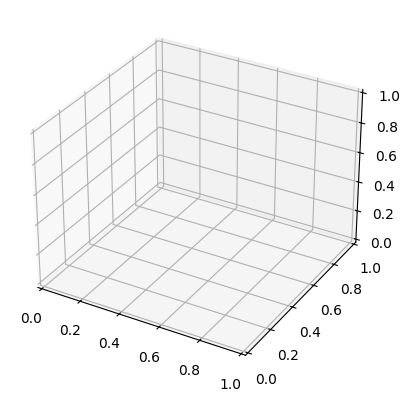

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_autoscale_on(False)

# Enable subtle 3D gridlines
ax.grid(True)

def connect_joints(position_3d_per_frame, ax):
    def plot_connection(start, end, color):
        connected_joints_transposed = np.transpose([position_3d_per_frame[start], position_3d_per_frame[end]])
        ax.plot3D(connected_joints_transposed[0], connected_joints_transposed[1], connected_joints_transposed[2], color=color, linewidth=2)

    # Left side (green)
    plot_connection(0, 4, 'green')  # hip - left hip
    plot_connection(4, 5, 'green')  # left hip - left knee
    plot_connection(5, 6, 'green')  # left knee - left foot
    plot_connection(11, 12, 'green')  # left shoulder - left elbow
    plot_connection(12, 13, 'green')  # left elbow - left wrist
    plot_connection(11, 8, 'green')  # left shoulder - thorax

    # Right side (blue)
    plot_connection(0, 1, 'blue')  # hip - right hip
    plot_connection(1, 2, 'blue')  # right hip - right knee
    plot_connection(2, 3, 'blue')  # right knee - right foot
    plot_connection(14, 15, 'blue')  # right shoulder - right elbow
    plot_connection(15, 16, 'blue')  # right elbow - right wrist
    plot_connection(14, 8, 'blue')  # right shoulder - thorax

    # Middle (black)
    plot_connection(8, 7, 'black')  # thorax - spine
    plot_connection(8, 9, 'black')  # thorax - neck/nose
    plot_connection(9, 10, 'black')  # neck/nose - head
    plot_connection(7, 0, 'black')  # spine - hip

def animate(i):
    # position_3d_per_frame = np.delete(vid[i], [4,5,9,10,11,16,20,21,22,23,24,28,29,30,31], 0)
    position_3d_per_frame = vid[i]

    ax.clear()
    ax.view_init(elev=-60, azim=-90)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

    # Set empty labels for each axis instead of removing the ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # Redraw gridlines subtly
    ax.grid(True)
    # Set the gridline properties for a very subtle effect
    ax.xaxis._axinfo['grid'].update(color='#D0D0D0', linestyle='-', linewidth=0.1)
    ax.yaxis._axinfo['grid'].update(color='#D0D0D0', linestyle='-', linewidth=0.1)
    ax.zaxis._axinfo['grid'].update(color='#D0D0D0', linestyle='-', linewidth=0.1)

    connect_joints(position_3d_per_frame, ax)


In [13]:
action = "random1"

count = 0
start_time = time()
vid_path_name = '/Inference/'+ action + '.mp4'
vid_name = os.path.basename(vid_path_name)[:-4]
cap = cv2.VideoCapture(vid_path_name)
if not cap.isOpened():
    print(f"Error: Could not open video file {vid_path_name}")

vid_fps = cap.get(cv2.CAP_PROP_FPS)

sequence = []
vid = []
while True:
    ret, im = cap.read()
    if not ret:
        break
    height, width = im.shape[:2]
    outputs = predictor(im)
    predicted = outputs["instances"].pred_keypoints.cpu().numpy()

    if len(predicted) > 0:
        predicted = coco2h36m(predicted)[0][..., :2]
        predicted = normalize_screen_coordinates(predicted, w=width, h=height)
    else:
        predicted = sequence[-1]
    sequence.append(predicted)
    count += 1

    if count %243 == 0:
        detected_2d = torch.tensor(np.array(sequence[-243:]))
        predicted_3D = get_3D_keypoints(detected_2d, action)
        # print(predicted_3D.shape)
        vid.append(predicted_3D)
cap.release()


vid = np.array(vid).reshape(-1, 17, 3)

detected_2d = torch.tensor(np.array(sequence[-243:]))
predicted_3D = get_3D_keypoints(detected_2d, action)

gap = count %243

vid = np.concatenate([vid, predicted_3D[-gap:]], axis=0)

/home/yen/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
print(vid.shape)

(286, 17, 3)


In [15]:
from time import time

# animate(0)
vid[:,0,:] = 0
ani = FuncAnimation(fig, animate, interval=10, frames = vid.shape[0])

# show the plot
# from IPython.display import HTML
# grap2eq_out = HTML(ani.to_html5_video())

ani.save('/Inference/' + action + '_3D.mp4', writer='ffmpeg', fps=vid_fps)

end_time = time()

FPS = end_time - start_time
FPS = vid.shape[0] / FPS

In [16]:
print(FPS)

5.682938733390367


In [17]:
import cv2
import numpy as np

video1_path = '//Inference/' + action + '.mp4'
video2_path = '/Inference/' + action + '_3D.mp4'

cap1 = cv2.VideoCapture(video1_path)
cap2 = cv2.VideoCapture(video2_path)

if not cap1.isOpened() or not cap2.isOpened():
    raise ValueError("Could not open one or both videos. Check paths.")

fps = min(cap1.get(cv2.CAP_PROP_FPS), cap2.get(cv2.CAP_PROP_FPS))

# Dimensions of the first video
frame_width1 = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Dimensions of the second video
frame_width2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Calculate the clipping coordinates for the middle third
clip_start_x = frame_width2 // 3 - 30
clip_end_x = clip_start_x * 2 + 100
clip_width2 = clip_end_x - clip_start_x

# Final frame height after resizing (match both videos' heights)
final_height = max(frame_height1, frame_height2)

# Resize widths while preserving aspect ratios
resize_width1 = int(frame_width1 * (final_height / frame_height1))
resize_width2 = int(clip_width2 * (final_height / frame_height2))
final_width = resize_width1 + resize_width2

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/Inference/' + action + '_combined_output.mp4', fourcc, fps, (final_width, final_height))

while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if not ret1 or not ret2:
        break

    # Clip the middle third horizontally from second video
    frame2_clipped = frame2[:, clip_start_x:clip_end_x]

    # Resize frames to match heights
    frame1_resized = cv2.resize(frame1, (resize_width1, final_height))
    frame2_resized = cv2.resize(frame2_clipped, (resize_width2, final_height))

    # Combine frames side-by-side
    combined_frame = np.hstack((frame1_resized, frame2_resized))

    out.write(combined_frame)

cap1.release()
cap2.release()
out.release()
cv2.destroyAllWindows()

print("Clipped videos combined successfully!")


Clipped videos combined successfully!
